# Bayesian CUPED

In this example notebook, we describe how to implement the Bayesian [CUPED](https://dl.acm.org/doi/abs/10.1145/2433396.2433413) estimator using NumPyro. This estimation method is very popular in the A/B testing community, and is a simple and effective way to reduce the variance of the difference in means estimator. We recommend the introductory blog post ["Understanding CUPED"](https://towardsdatascience.com/understanding-cuped-a822523641af) by [Matteo Courthoud](https://medium.com/@matteo.courthoud). We will use the same case study data as in Matteo's blog post

**Remark:** This example has been adapted from the blog post ["Bayesian CUPED & Sensitivity Analysis"](https://juanitorduz.github.io/bayesian_cuped/).


## Prepare Notebook

In [ ]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro arviz matplotlib polars seaborn

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

from jax import Array, random
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=1)

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

assert numpyro.__version__.startswith("0.19.0")

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Data

We generate synthetic data from a (synthetic) company evaluating the revenue impact of a new ad campaign. Users are randomly divided into two groups: one exposed to the campaign (treatment) and one not (control). We use a synthetic dataset from Matteo's repository [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). One key ingredient for CUPED is to have a pre-experiment for the relevant variables. We simulate a pre and post experiment `revenue` variable under the presence of an intervention `ad_campaign` in a randomized controlled trial.

In [2]:
def generate_data(
    rng_key: Array,
    alpha: float = 5,
    beta: float = 0,
    gamma: float = 3,
    delta: float = 2,
    n: int = 100,
):
    # Individuals
    individual = range(1, n + 1)

    # Treatment status
    rng_key, rng_subkey = random.split(rng_key)
    d = random.binomial(rng_subkey, n=1, p=0.5, shape=n)

    # Individual outcome pre-treatment
    rng_key, rng_subkey = random.split(rng_key)
    y0 = alpha + beta * d + random.normal(rng_subkey, shape=n)

    # Individual outcome post-treatment
    rng_key, rng_subkey = random.split(rng_key)
    y1 = y0 + gamma + delta * d + random.normal(rng_subkey, shape=n)

    # Generate the dataframe
    return pl.DataFrame(
        {
            "individual": np.array(individual),
            "ad_campaign": np.array(d),
            "revenue0": np.array(y0),
            "revenue1": np.array(y1),
        }
    )


rng_key, rng_subkey = random.split(rng_key)
data_df = generate_data(rng_subkey)

data_df.head()

individual,ad_campaign,revenue0,revenue1
i64,f32,f32,f32
1,1.0,4.825495,8.937075
2,0.0,4.05688,5.443201
3,0.0,6.114765,7.075873
4,0.0,4.204422,7.126404
5,0.0,5.328116,9.85461


From the data generating process, we know the true average treatment effect is $\delta=2$.

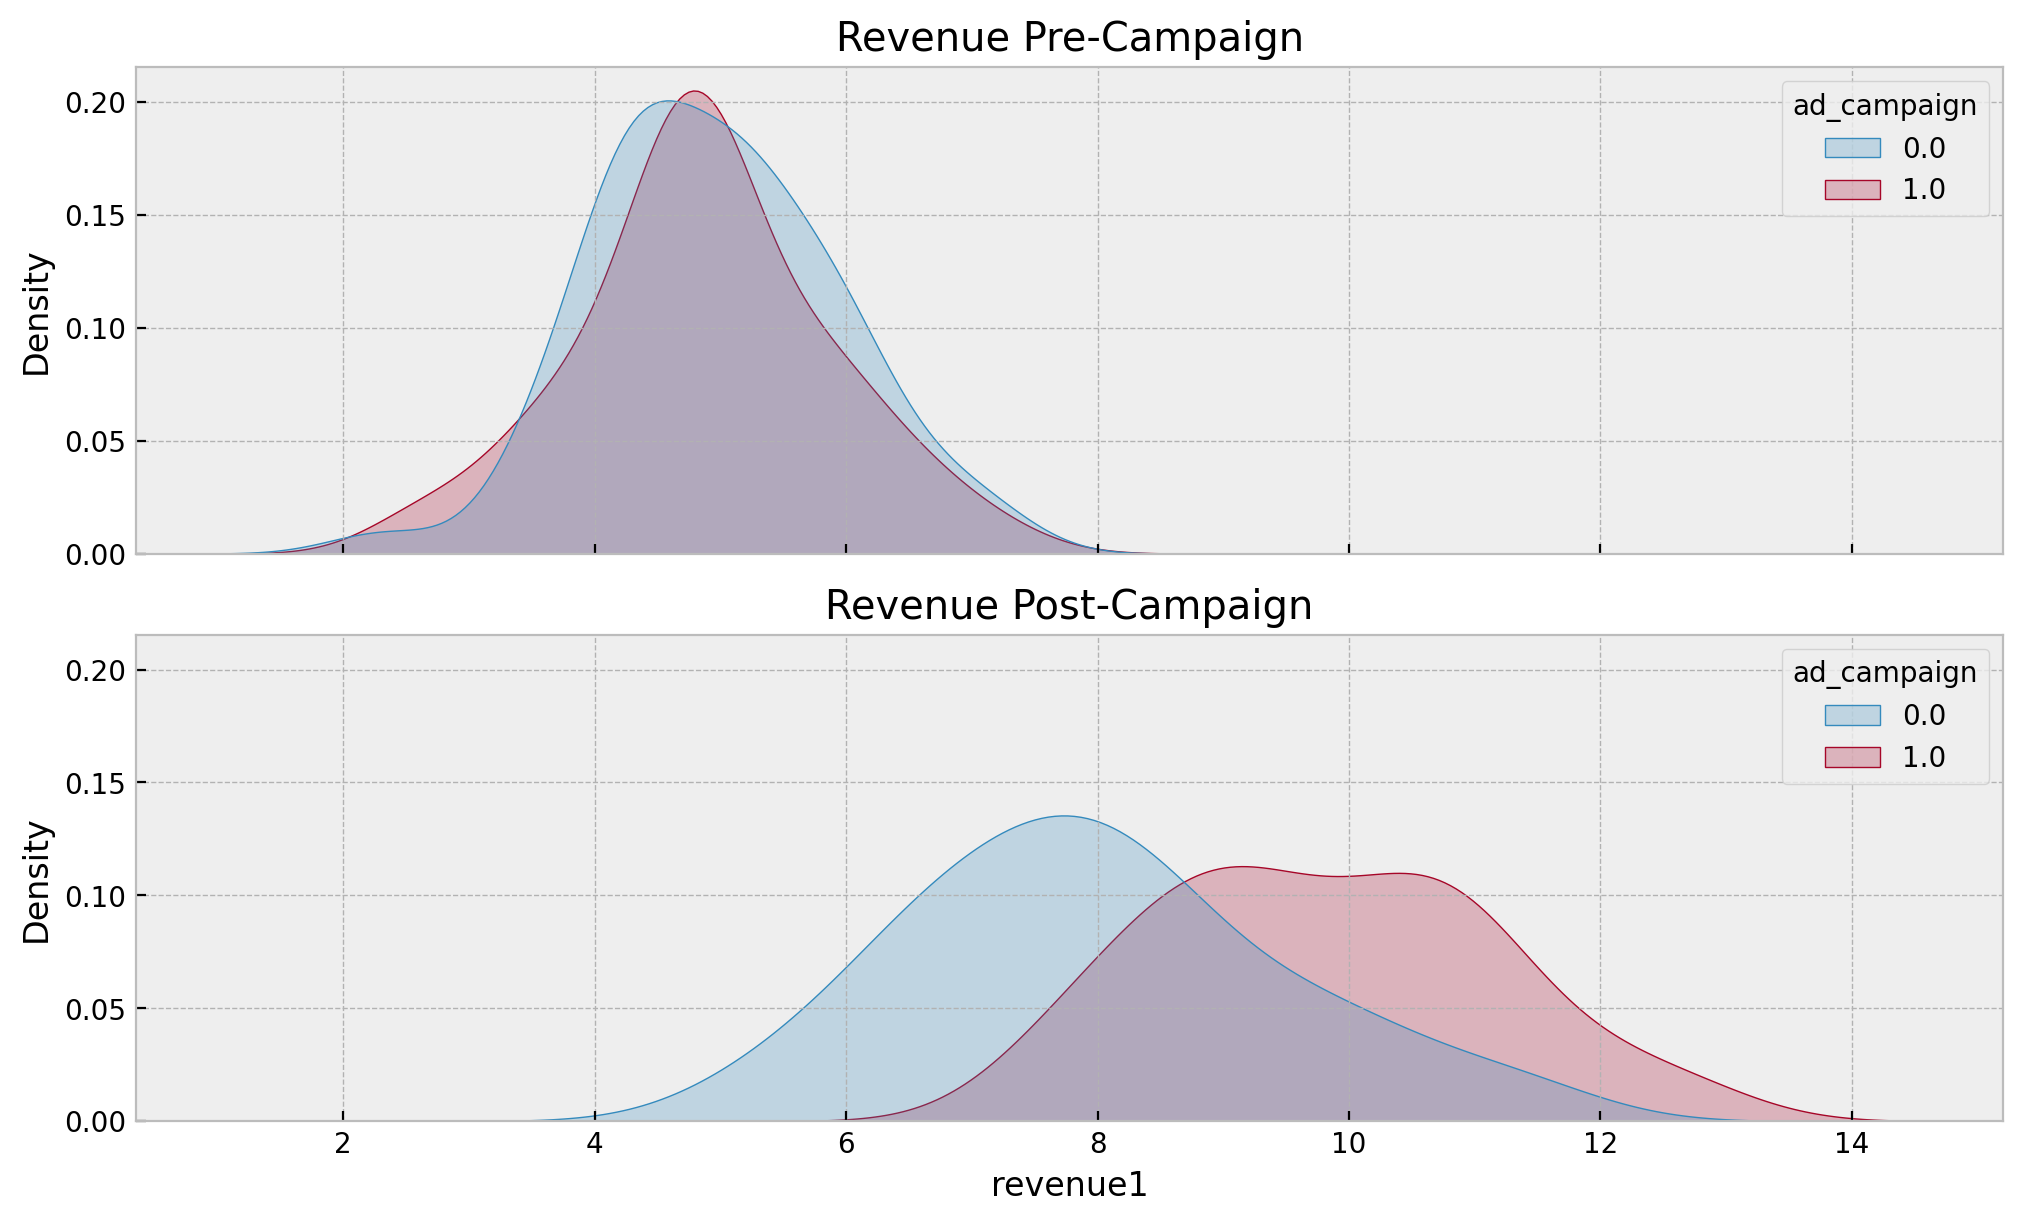

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, layout="constrained")

sns.kdeplot(data=data_df, x="revenue0", hue="ad_campaign", fill=True, ax=ax[0])
ax[0].set_title("Revenue Pre-Campaign")

sns.kdeplot(data=data_df, x="revenue1", hue="ad_campaign", fill=True, ax=ax[1])
ax[1].set_title("Revenue Post-Campaign");

## Effect Estimation: Difference in Means

First, we compute the point estimate of the difference in means as follows:

In [4]:
difference_in_means = (
    data_df.filter(pl.col("ad_campaign") == pl.lit(1.0))["revenue1"].mean()
    - data_df.filter(pl.col("ad_campaign") == pl.lit(0.0))["revenue1"].mean()
)

print(f"Difference in means: {difference_in_means:.3f}")

Difference in means: 1.825


We are of course interested in quantifying the uncertainty of this estimate. We can do this using a simple linear regression model. We use a Bayesian approach with non-very informative priors, to be able to compare the results with the CUPED approach.

In [5]:
ad_campaign = data_df["ad_campaign"].to_jax()
revenue0 = data_df["revenue0"].to_jax()
revenue1 = data_df["revenue1"].to_jax()

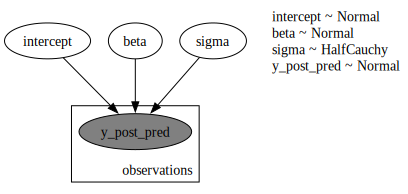

In [6]:
def difference_in_means_model(y_post: Array, treatment: Array) -> None:
    n_samples = len(treatment)
    intercept = numpyro.sample("intercept", dist.Normal(loc=0, scale=2))
    beta = numpyro.sample("beta", dist.Normal(loc=0, scale=3))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(scale=2))

    mu = intercept + beta * treatment

    with numpyro.plate("observations", n_samples):
        numpyro.sample("y_post_pred", dist.Normal(mu, sigma), obs=y_post)


numpyro.render_model(
    difference_in_means_model,
    model_args=(revenue1, ad_campaign),
    render_distributions=True,
    render_params=True,
)

We can estimate the beta coefficient using MCMC:

In [7]:
mcmc_difference_in_means = MCMC(
    sampler=NUTS(difference_in_means_model),
    num_warmup=1_000,
    num_samples=2_000,
    num_chains=4,
)

rng_key, rng_subkey = random.split(rng_key)
mcmc_difference_in_means.run(rng_subkey, revenue1, ad_campaign)

idata_difference_in_means = az.from_numpyro(mcmc_difference_in_means)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

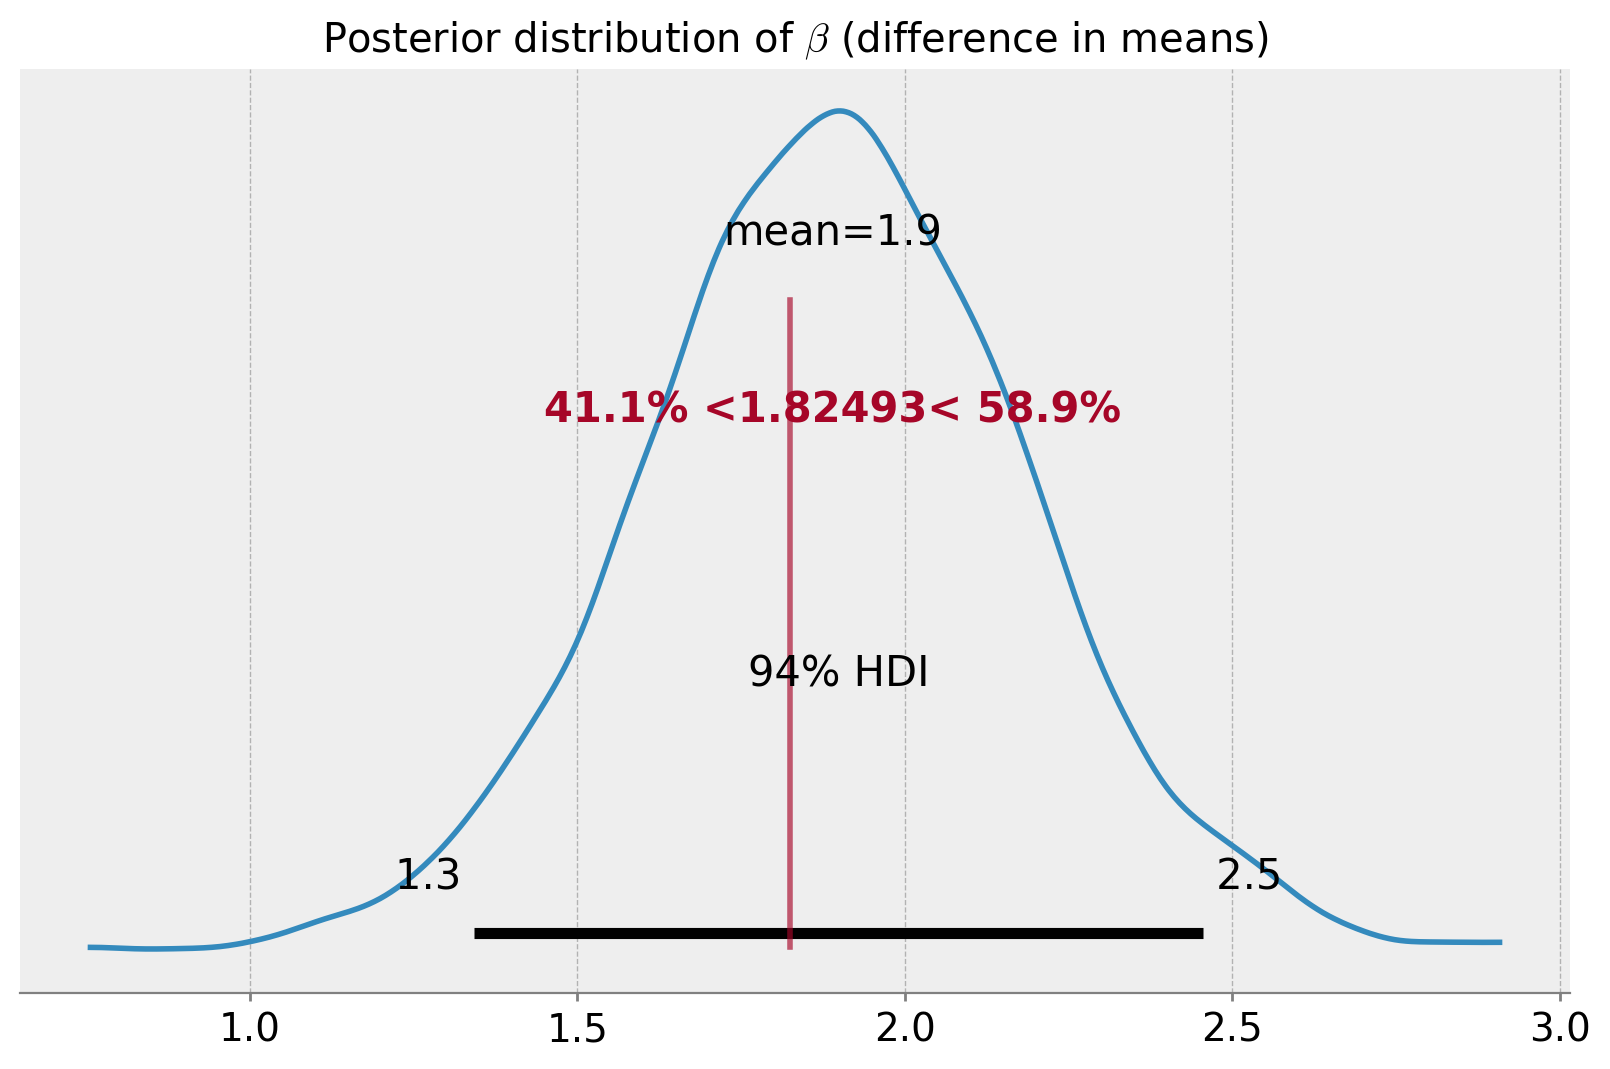

In [8]:
fig, ax = plt.subplots()
az.plot_posterior(
    idata_difference_in_means, var_names=["beta"], ref_val=difference_in_means, ax=ax
)
ax.set_title(r"Posterior distribution of $\beta$ (difference in means)");

As expected, the posterior distribution of the difference in means is centered around the true value of $2$ (from the data generating process).

Let's compute the standard deviation of the posterior distribution:

In [9]:
print(f"std: {idata_difference_in_means['posterior']['beta'].std().item():.3f}")

std: 0.292


Let's see if we can do better using the CUPED estimator.

## Bayesian CUPED

We now turn to the Bayesian CUPED approach. Recall the algorithm for the CUPED estimator:

1. Regress $\text{revenue}_1$ on $\text{revenue}_0$ and estimate the $\theta$ coefficient.
2. Compute $\text{revenue}_{cuped} = \bar{\text{revenue}}_1 - \theta \times \bar{\text{revenue}}_0$.
3. Compute the difference in means of $\text{revenue}_{cuped}$ between treatment and control group.

NumPyro allows us to implement this algorithm in a single model.

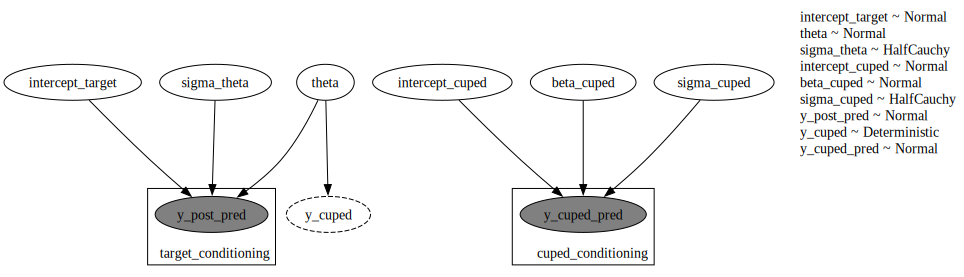

In [10]:
def cuped_model(y_post: Array, treatment: Array, y_pre: Array) -> None:
    n_samples = len(ad_campaign)

    intercept_target = numpyro.sample("intercept_target", dist.Normal(loc=0, scale=2))
    theta = numpyro.sample("theta", dist.Normal(loc=0, scale=3))
    sigma_theta = numpyro.sample("sigma_theta", dist.HalfCauchy(scale=2))

    intercept_cuped = numpyro.sample("intercept_cuped", dist.Normal(loc=0, scale=2))
    beta_cuped = numpyro.sample("beta_cuped", dist.Normal(loc=0, scale=3))
    sigma_cuped = numpyro.sample("sigma_cuped", dist.HalfCauchy(scale=2))

    mu_target = intercept_target + theta * y_pre

    with numpyro.plate("target_conditioning", n_samples):
        numpyro.sample("y_post_pred", dist.Normal(mu_target, sigma_theta), obs=y_post)

    y_cuped = numpyro.deterministic(
        "y_cuped", y_post - theta * (y_pre - jnp.mean(y_pre))
    )

    with numpyro.plate("cuped_conditioning", n_samples):
        numpyro.sample(
            "y_cuped_pred",
            dist.Normal(intercept_cuped + beta_cuped * treatment, sigma_cuped),
            obs=y_cuped,
        )


numpyro.render_model(
    cuped_model,
    model_args=(revenue1, ad_campaign, revenue0),
    render_distributions=True,
    render_params=True,
)

AS before, let's fit the model using MCMC:

In [11]:
mcmc_cuped = MCMC(
    sampler=NUTS(cuped_model),
    num_warmup=1_000,
    num_samples=2_000,
    num_chains=4,
)
rng_key, rng_subkey = random.split(rng_key)
mcmc_cuped.run(rng_subkey, revenue1, ad_campaign, revenue0)
idata_cuped = az.from_numpyro(mcmc_cuped)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Let's look into the posterior distribution of the CUPED effect estimate:

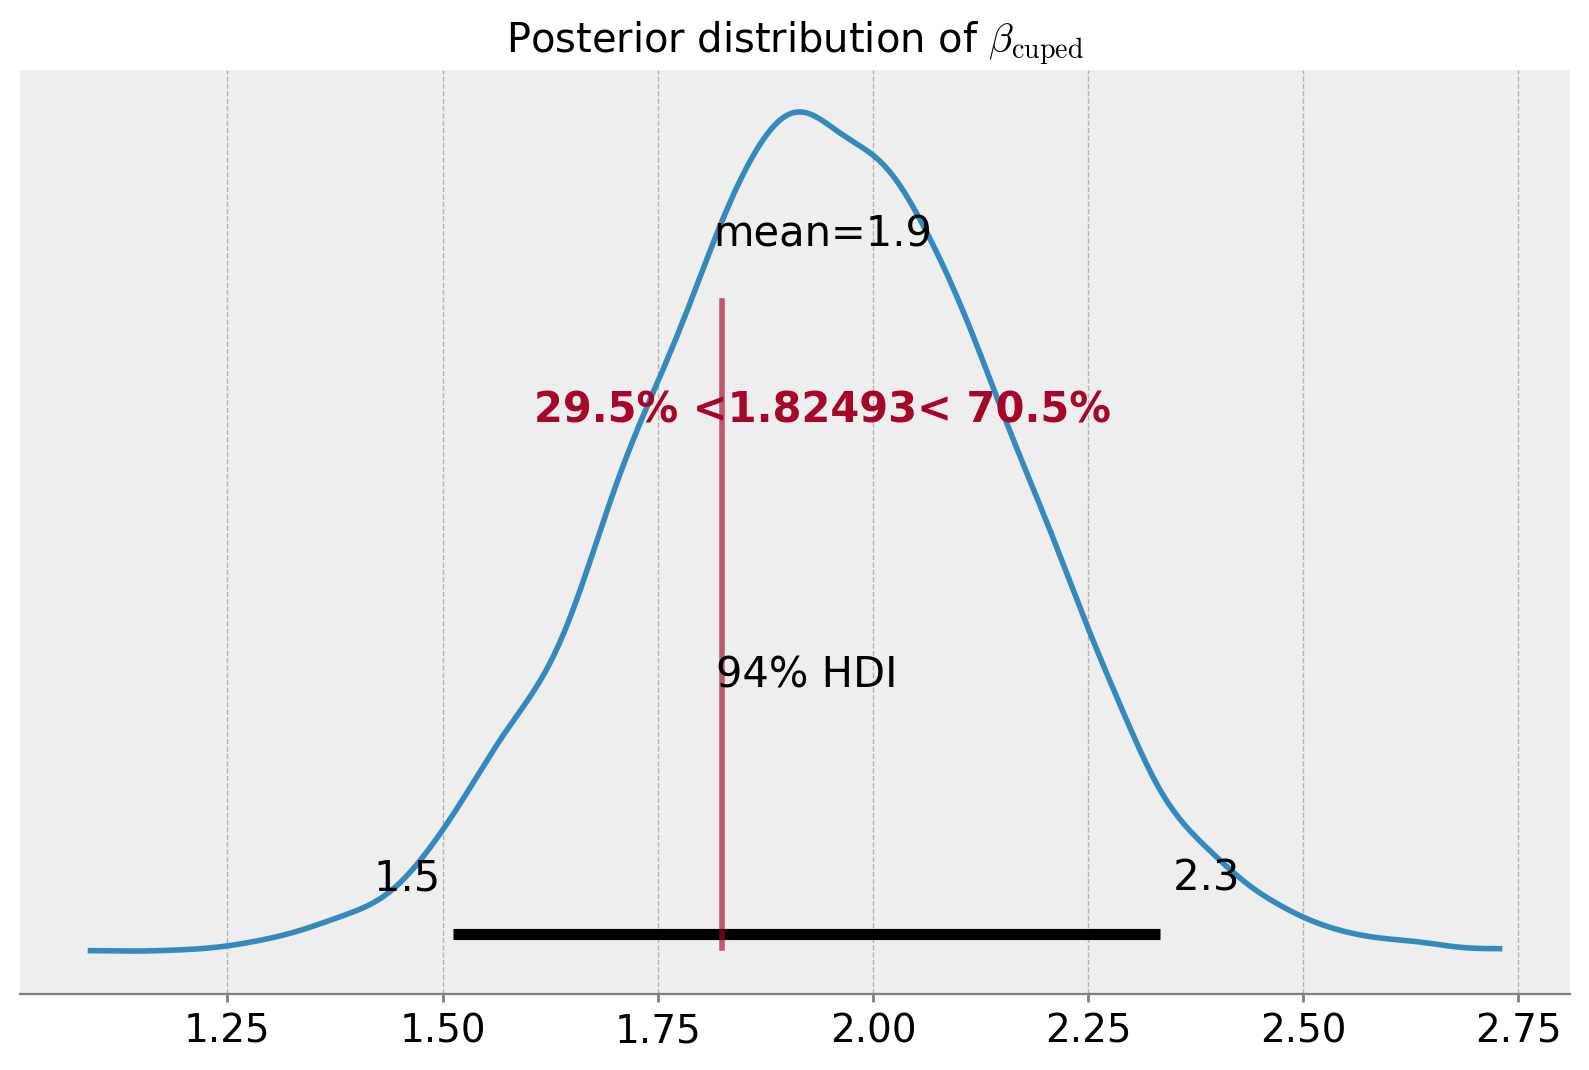

In [12]:
fig, ax = plt.subplots()
az.plot_posterior(
    idata_cuped, var_names=["beta_cuped"], ref_val=difference_in_means, ax=ax
)
ax.set_title(r"Posterior distribution of $\beta_{\text{cuped}}$");

In [13]:
print(f"std: {idata_cuped['posterior']['beta_cuped'].std().item():.3f}")

std: 0.219


As expected, the posterior distribution of the CUPED effect estimate is narrower than the one of the simple difference in means.

Finally, let's compare the posterior distributions of the difference in means and the CUPED effect estimate against the point estimate of the difference in means.

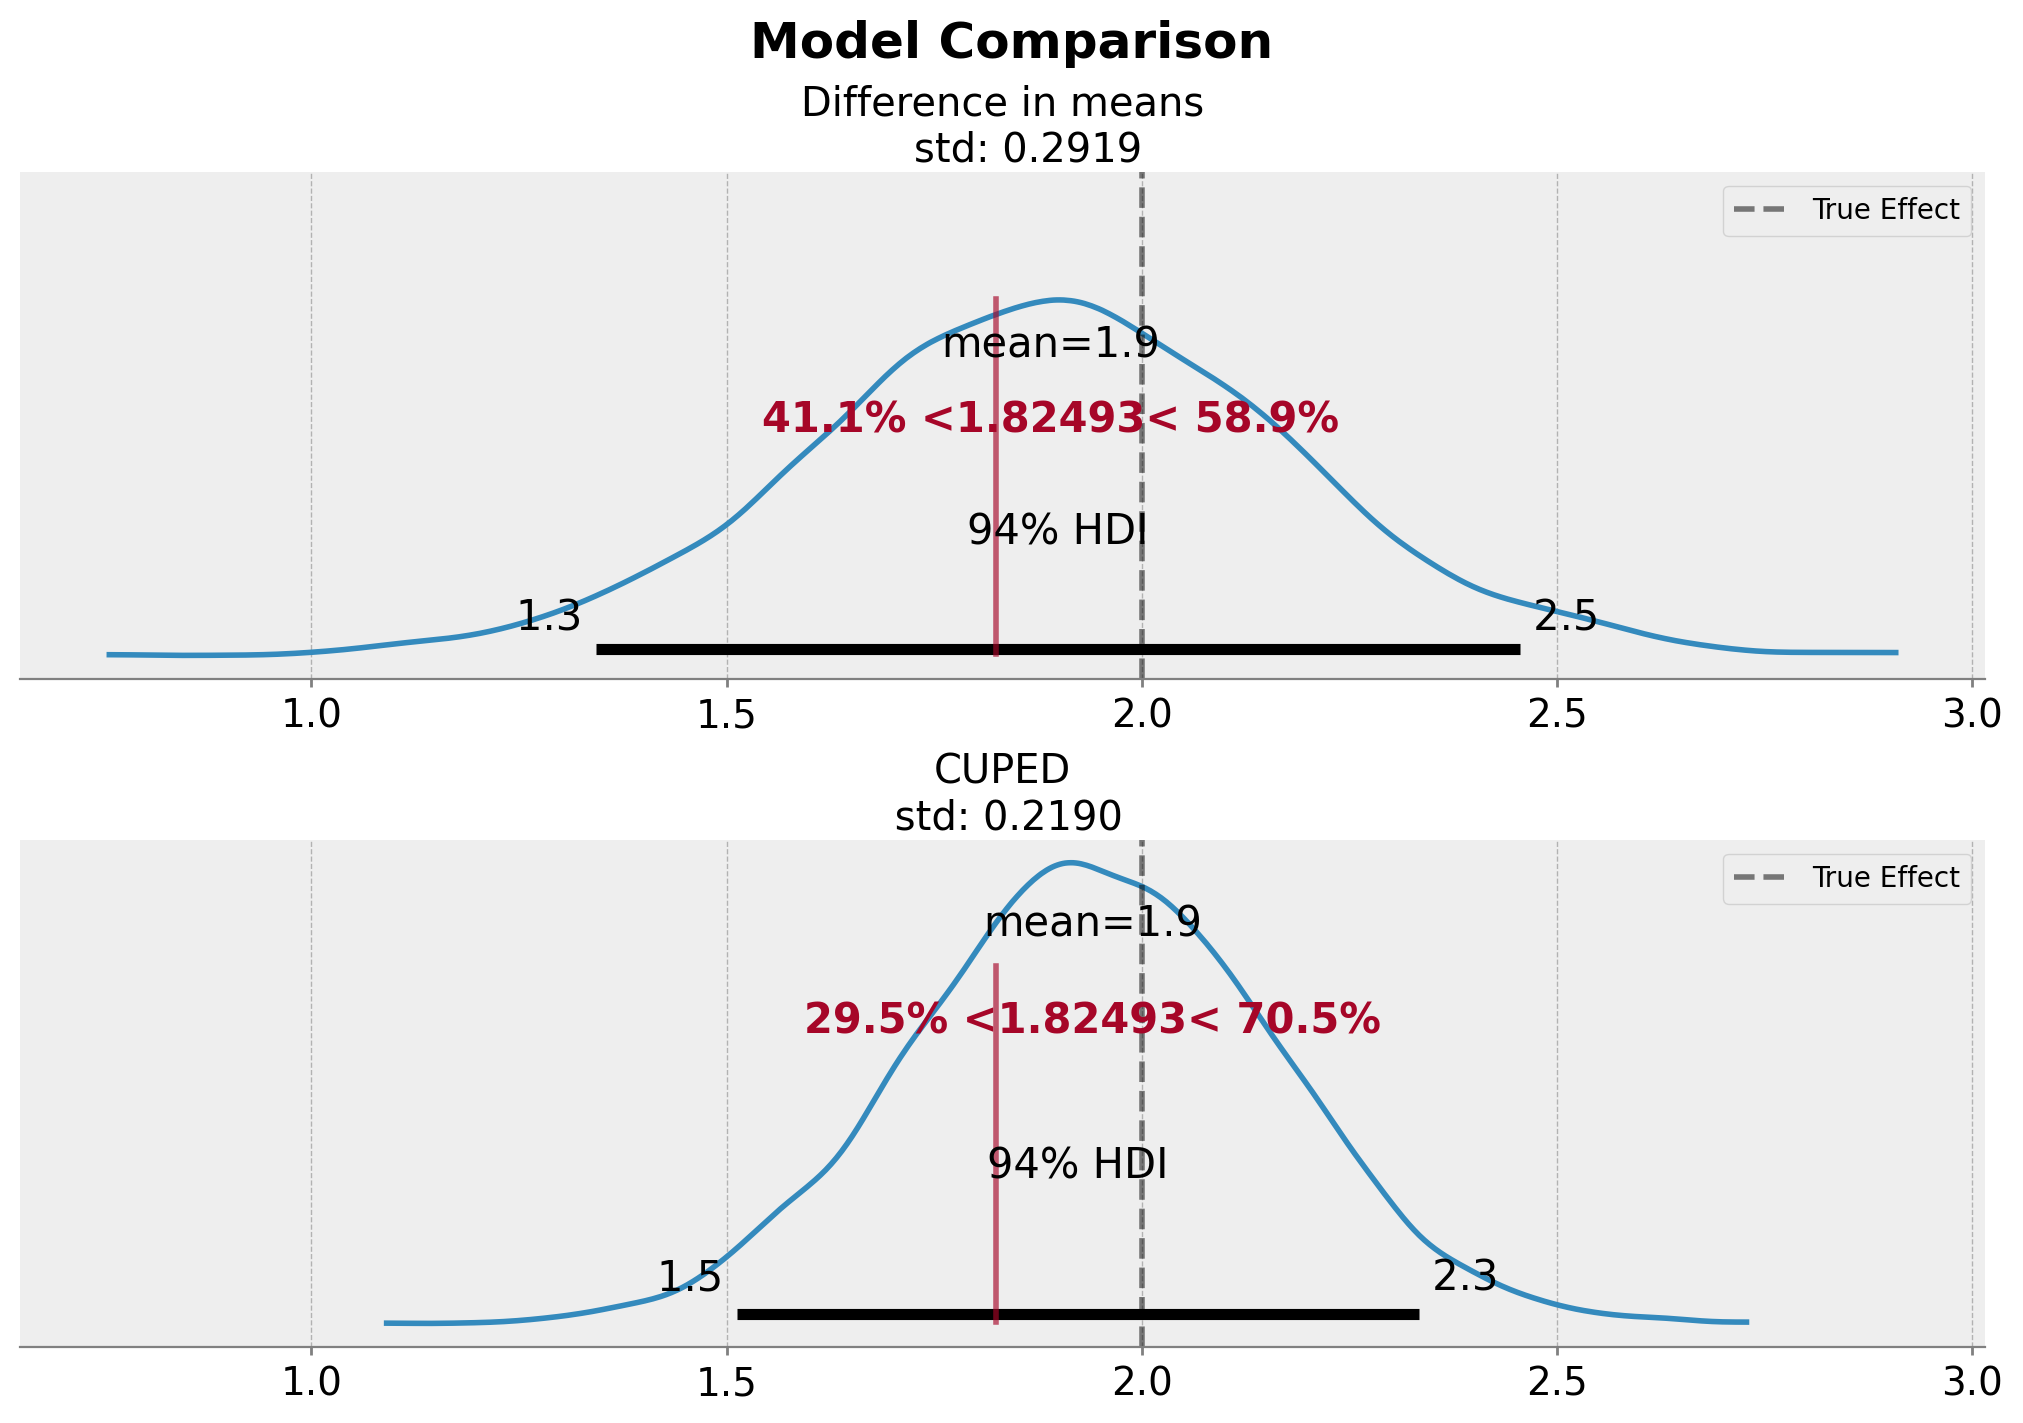

In [14]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

az.plot_posterior(
    idata_difference_in_means, var_names=["beta"], ref_val=difference_in_means, ax=ax[0]
)
ax[0].axvline(2, color="k", linestyle="--", alpha=0.5, label="True Effect")
ax[0].legend()
ax[0].set_title(
    f"""Difference in means
    std: {idata_difference_in_means["posterior"]["beta"].std().item():.4f}"""
)

az.plot_posterior(
    idata_cuped, var_names=["beta_cuped"], ref_val=difference_in_means, ax=ax[1]
)
ax[1].axvline(2, color="k", linestyle="--", alpha=0.5, label="True Effect")
ax[1].legend()
ax[1].set_title(
    f"CUPED\n std: {idata_cuped['posterior']['beta_cuped'].std().item():.4f}"
)

fig.suptitle("Model Comparison", fontsize=18, fontweight="bold");

Here we have a clear visual evidence of the variance reduction by the CUPED model.